In [1]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from google.colab import drive

In [2]:
# Esto es para usar la gpu y no la cpu de mi pc
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


In [3]:
# Load data and print examples
drive.mount('/content/drive')
Ruta_Archivo = '/content/drive/MyDrive/Ventas_Hora_V2.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load data
Datos=pd.read_csv(Ruta_Archivo,header=0, sep=";", decimal=",")
Datos.head()

,Fecha,Q_Ventas
0,1-6,10
1,1-7,29
2,1-8,68
3,1-9,60
4,1-10,58


In [5]:
Datos.describe()

,Q_Ventas
count,2978.000000
mean,88.694090
std,62.929562
min,1.000000
25%,42.000000
50%,82.000000
75%,117.000000
max,348.000000


In [6]:
Train_size = Datos.iloc[:2500]
Test_size = Datos.iloc[2500:2978]

In [7]:
len(Train_size)

2500

In [8]:
len(Test_size)

478

In [9]:
Train_size.tail()

,Fecha,Q_Ventas
2495,17-8,61
2496,17-9,75
2497,17-10,112
2498,17-11,91
2499,17-12,75


In [10]:
Test_size.head()

,Fecha,Q_Ventas
2500,17-13,65
2501,17-14,74
2502,17-15,62
2503,17-16,59
2504,17-17,83


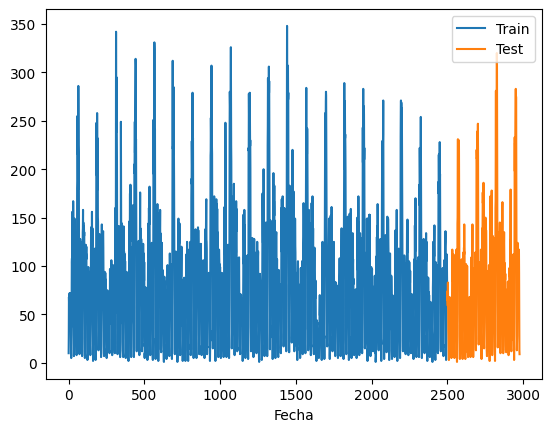

In [11]:
plt.plot(Train_size['Q_Ventas'])
plt.plot(Test_size['Q_Ventas'])
plt.legend(['Train', 'Test'])
plt.xlabel('Fecha')
plt.show()

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

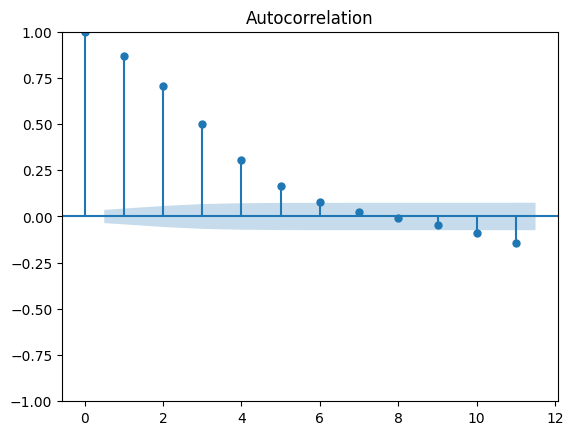

In [13]:
# Calcular y graficar la ACF
plot_acf(Datos['Q_Ventas'], lags=11)
plt.show()

In [14]:
Train_size['Q_Ventas'].shape

(2500,)

In [15]:
Train_reshape = Train_size['Q_Ventas'].to_numpy().reshape(-1, 1)
Test_reshape = Test_size['Q_Ventas'].to_numpy().reshape(-1, 1)

In [16]:
Train_reshape.shape

(2500, 1)

In [17]:
Test_reshape.shape

(478, 1)

In [18]:
Train_reshape[0:5]

array([[10],
       [29],
       [68],
       [60],
       [58]])

In [19]:
# Esto si cambia los datos y los escala de -1 a 1. Este escalamiento ayuda para el modelado por los algoritmos de optimización como gd entre otros
scaler = StandardScaler()
Datos_Train = scaler.fit_transform(Train_reshape).flatten().tolist()
Datos_Test = scaler.transform(Test_reshape).flatten().tolist()

In [20]:
Sequence_Size = 7

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [21]:
x_train, y_train = to_sequences(Sequence_Size, Datos_Train)
x_test, y_test = to_sequences(Sequence_Size, Datos_Test)

In [22]:
len(x_train), len(y_train), len(x_test), len(y_test)

(2493, 2493, 471, 471)

Ojo que si saco samples de a 10, solo puedo sacar 14 muestras de un dataset de 24 timestep

In [23]:
x_train.shape

torch.Size([2493, 7, 1])

In [24]:
y_train.shape

torch.Size([2493, 1])

In [25]:
x_train[0], y_train[0]

(tensor([[-1.2530],
         [-0.9526],
         [-0.3359],
         [-0.4624],
         [-0.4941],
         [-0.3676],
         [-0.2727]]),
 tensor([-0.6205]))

In [26]:
# Generación de tensores para modelar. esto es propio de pytorc, está creando un data set con variables y etiquetas.
train_dataset = TensorDataset(x_train, y_train)

In [27]:
train_dataset[0]

(tensor([[-1.2530],
         [-0.9526],
         [-0.3359],
         [-0.4624],
         [-0.4941],
         [-0.3676],
         [-0.2727]]),
 tensor([-0.6205]))

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Revisar si usaré ese tamaño de batch, debería cambiarlo.

In [29]:
# mismo procedimiento pero para test. acá se usó el false
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
# Codificación posicional para uso en transformers:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Crear una matriz de ceros con dimensiones (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Crear una matriz de posiciones desde 0 hasta max_len
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calcular la relación de división para las posiciones pares
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        # Aplicar sinusoide a las posiciones pares
        pe[:, 0::2] = torch.sin(position * div_term)

        # Aplicar cosenoide a las posiciones impares
        pe[:, 1::2] = torch.cos(position * div_term)

        # Añadir una dimensión adicional y transponer
        pe = pe.unsqueeze(0).transpose(0, 1)

        # Registrar 'pe' como un buffer para evitar que sea un parámetro entrenable
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Añadir la codificación posicional al tensor de entrada
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [31]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [32]:
# Criterios de entrenamiento

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 100
early_stop_count = 0
min_val_loss = float('inf')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [33]:
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

 #   if val_loss < min_val_loss:
  #      min_val_loss = val_loss
    #    early_stop_count = 0
   # else:
    #    early_stop_count += 1

    #if early_stop_count >= 5:
     #   print("Early stopping!")
      #  break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/100, Validation Loss: 0.2599
Epoch 2/100, Validation Loss: 0.2490
Epoch 3/100, Validation Loss: 0.2459
Epoch 4/100, Validation Loss: 0.2414
Epoch 5/100, Validation Loss: 0.2830
Epoch 6/100, Validation Loss: 0.2462
Epoch 7/100, Validation Loss: 0.2498
Epoch 8/100, Validation Loss: 0.2493
Epoch 9/100, Validation Loss: 0.2492
Epoch 10/100, Validation Loss: 0.2424
Epoch 11/100, Validation Loss: 0.2600
Epoch 12/100, Validation Loss: 0.2574
Epoch 13/100, Validation Loss: 0.2375
Epoch 14/100, Validation Loss: 0.2489
Epoch 15/100, Validation Loss: 0.2378
Epoch 16/100, Validation Loss: 0.2476
Epoch 17/100, Validation Loss: 0.2412
Epoch 18/100, Validation Loss: 0.2488
Epoch 19/100, Validation Loss: 0.2446
Epoch 20/100, Validation Loss: 0.2483
Epoch 21/100, Validation Loss: 0.2463
Epoch 22/100, Validation Loss: 0.2392
Epoch 23/100, Validation Loss: 0.2369
Epoch 24/100, Validation Loss: 0.2397
Epoch 25/100, Validation Loss: 0.2405
Epoch 26/100, Validation Loss: 0.2383
Epoch 27/100, Validat

In [34]:
# Evaluation
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Score (RMSE): {rmse:.4f}")

Score (RMSE): 30.7910


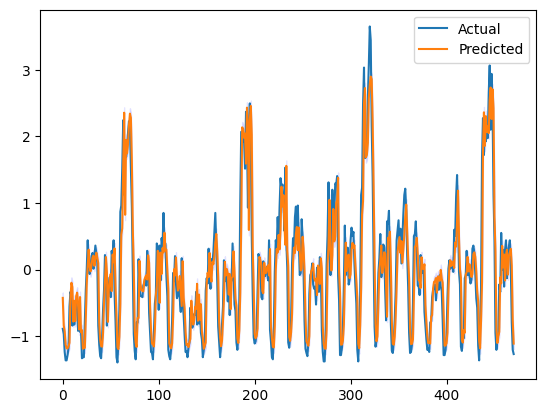

In [38]:
plt.plot(y_test.numpy(), label='Actual')
plt.plot(predictions, label='Predicted')
confidence = 1.96 * np.std(predictions) / np.sqrt(len(predictions))  # Intervalo de confianza del 95%
plt.fill_between(np.arange(len(predictions)), predictions - confidence, predictions + confidence, color='blue', alpha=0.1)
plt.legend()

In [35]:
Media=np.mean(scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))

In [36]:
Media

86.112526

In [37]:
rmse/Media

0.35756669164320865

In [40]:
Test_Escalado=scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

In [41]:
Prediccion_Escalada=scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

In [ ]:
# El test es del tamaño del total de samples que pueda sacar. Ojo Este es el mejor modelo hasta ahora con 1 en timestep, porque tengo muy poquitos datos. con 2 timestep da 12% de error, es mejor aún.
# con 3 empeora el error y sube a 15%, con 4 empeora a 21% esto tiene sentido porque el set de datos es pequeño. con 6 mejora volviendo a 17%, con 7 empeora a 20%.
# lo mejor es usar timestep=2 o 1 cuando la data es pequeña, esto es con batchsize de 32.

# Si bajo el batchsize a 1 eso se daña terriblemente.

# Mejor modelo  es 32 batch y 2 timestep, 64 en dmodel



In [ ]:
# Suponiendo train_predictions y y_train son numpy arrays
def calculate_rmse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Ejemplo de uso
RSME = calculate_rmse(predictions, y_test.numpy())
print(f'RMSE: {rmse:.2f}')

RMSE: 30.79
